In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

import numpy as np
import cv2
from PIL import Image

import os
from options.test_options import TestOptions
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images
from util import html
import torch
import torchvision
import torchvision.transforms as transforms

from helper_demo import helper

# Restart IPython kernel to take changes into effect after editing a module

### Create model architecture / Load latest model weights / Create cartoon dataset

In [15]:
# setup cyclegan model using the training options
opt = helper.setup_options()
#opt.name="cartoonfaces"
opt.name="cartoonfaces-ld0_0001"
#opt.name="cartoonfaces-ld0_00001"

model = create_model(opt)
model.isTrain = False
model.setup(opt)

# setup dataset
dataset = create_dataset(opt)

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./datasets/faces              
             dataset_mode: face                          
                direction: AtoB                          
              display_env: main                          
             display_freq: 100                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              epoch_count: 1  

### Convert faces to cartoons (forward pass through the network)

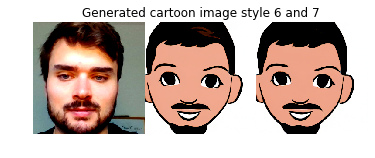

In [16]:
from IPython.display import clear_output

# set the brightness in order to enhance captures in a 
# dark environment (default 0.5)
brightness = 0.3 # lower enhances darker environments

# control the "zoom" with the framesize:
# 256x256 will be cropped out from the center.
# use this as initial frame size:
framesize = 500

# capture on webcam
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_BUFFERSIZE, 1);
# use the hflip for "demirrored" webcams
transform = transforms.Compose([torchvision.transforms.functional.hflip,
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize((brightness, brightness, brightness),
                                                (0.5, 0.5, 0.5))])

style = 0
style2 = 1
style_counter = True

try:
    while(True):
        # drop capture buffer (the easy way)
        ret, frame = cap.read()
        ret, frame = cap.read()
        ret, frame = cap.read()
        
        # update style
        if style_counter:
            style = ((style + 1) % 10)
            style2 = ((style2 + 1) % 10)

        # scale the image and convert to RGB
        hight, width, depth = frame.shape
        crop_pixel = int((width - hight)/2) # crop square
        cropped_frame = frame[:, crop_pixel:width-crop_pixel]
        resized_frame = cv2.resize(cropped_frame, (framesize, framesize))
        cvframe = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB) 
        
        # transform the capture to an PIL image
        pil_img = Image.fromarray(cvframe)
        img = transform(pil_img)
        img = img.view(1, 3, 256, 256)
        img_A = helper.to_image(img[0, :, :, :])
        
        img_B = model.gen_B(img, style+1)
        img_B2 = model.gen_B(img, style2+1)
        #torchvision.utils.save_image(img_B[0, :, :, :], 'comic.png')
        img_B = helper.to_image(img_B[0, :, :, :])
        img_B2 = helper.to_image(img_B2[0, :, :, :])
        img_AB = helper.concatenate([img_A, img_B, img_B2])
        img_AB.save('comic.jpg')
        
        clear_output()
        plt.axis('off')
        plt.title('Generated cartoon image style {} and {}'.format(style+1, style2+1))
        plt.imshow(img_AB)
        plt.show()        
    
except KeyboardInterrupt:
    # you have to interrupt the kernel to break the loop:
    cap.release()
   


In [7]:
cap.release()

If the image is too dark, put a lamp in front of your face (classical computer vision trick). You can finetune with the brightness property.

### Bonus: convert cartoons to faces

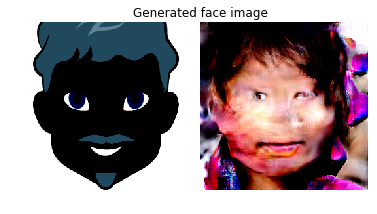

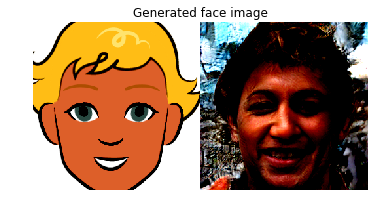

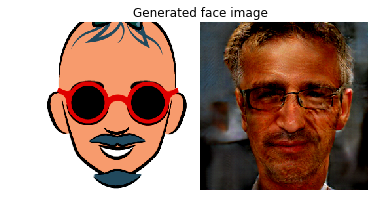

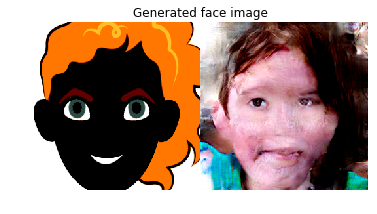

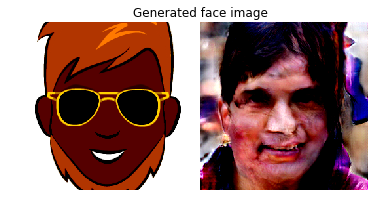

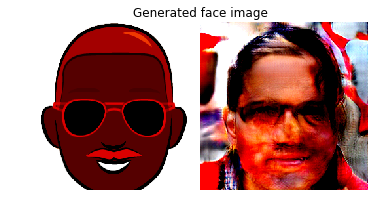

In [8]:
for i, data in enumerate(dataset):
    if (i > 5):
        break
    
    theB = data['B']
    real_B = theB['img']
    img_B = helper.to_image(real_B[0,:,:,:])
    img_A = model.gen_A(real_B)
    img_A = helper.to_image(img_A[0,:,:,:])
    img_BA = helper.concatenate([img_B, img_A])
    img_BA.save('real.jpg')
    
    plt.axis('off')
    plt.title('Generated face image')
    plt.imshow(img_BA)
    plt.show()
    

### Interactive visualization

In [ ]:
## demo code to have a slider for the conditional version

import ipywidgets as wg
import matplotlib.pyplot as plt

class interactive_plot:

    def __init__(self,r):
        self.X = [x for x in range(r)]
        self.Y = [y for y in range(r)]
        self.r = r
        self.fig = None
        self.ax = None

    def pathPlot(self, xframe = None):

        if self.fig is None:
            self.fig = plt.figure()
            self.ax =self.fig.add_subplot(1,1,1)
            self.ax.plot(self.X, self.Y, 'bo-')

        else:
            self.fig = plt.gcf()
            self.ax = plt.gca()
            self.ax.plot(self.X, self.Y, 'bo-')

        if xframe is not None:
            self.ax.axvline(x = self.X[xframe],color = 'black',linestyle = '--')
            self.ax.plot(self.X[xframe],self.Y[xframe], 'ro', markersize=10)

    def pathPlay(self):

        frame = wg.IntSlider(min = 0, max = self.r - 1)
        wg.interact(self.pathPlot, xframe = frame)

test = interactive_plot(10)
test.pathPlay()